# Learning to use NLP features and Pipelines

Especially pipelines!

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

# pipelines
from sklearn.pipeline import Pipeline

# NLP transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# classifiers you can use
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold

# evaluation
from sklearn.metrics import f1_score, accuracy_score

# dataset
from sklearn.datasets import fetch_20newsgroups

# plotting
from plotting import plot_learning_curve, plot_validation_curve

# Loading the data

We are going to be using the 20 News Groups dataset available from [here](http://qwone.com/~jason/20Newsgroups/).  The data is a bunch of news articles, grouped into 20 news groups!

Our goal is to classify the documents, into the category it belongs to.  The skills we learn in this assignment will be the following

* basics of NLP (tf-idf, n-grams)
* how to use pipelines
* practice with the scikit-learn dummy model

Note that when we load the data we are going to exclude the follow columnts: "headers", "footers", and "quotes" as these are meta-data columns which provide extra information about the news articles.  These features are manually added, so we are removing them since we'd like to try and learn what class an article belongs to using the information present in the article alone.  

**NOTE**
Due to the way this data is stored, it's actually easier to leave it in it's native format (list and array) from sci-kit learn. So we won't be bothering with pandas here.

In [4]:
data = fetch_20newsgroups(categories = [ 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'],remove=('headers', 'footers', 'quotes'))

In [5]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [6]:
for i,name in enumerate(data.target_names):
    print (f"{i} is {name}")

0 is comp.graphics
1 is comp.os.ms-windows.misc
2 is comp.sys.ibm.pc.hardware
3 is talk.politics.guns
4 is talk.politics.mideast
5 is talk.religion.misc


Now we have only loaded in two topic types "computer" and "talk". Furether, I selected only 6 totaltopics from the 20 total that the dataset has to offer. Further we are going to simplify the problem even further, and lump together the two topics into two general topics.  Why?  Because otherwise it takes quite a while to run a single model on this dataset.  After you have built a decent model and tuned it, then you can try loading in more data and attempting to do multi-class classification.  For now we will focus on a simpler binary classification problem

In [7]:
## ONLY RUN THIS CELL ONCE ###
## RUNNING IT MULTIPLE TIMES WILL BREAK EVERYTHING ### turn this in to binary class classification, it will replace the 1, 2 =0 and 3, 4, 5 = 1

# set the 3 computer targets to one label
data.target[data.target == 1] = 0
data.target[data.target == 2] = 0

# set 3 talk targets to one label
data.target[data.target == 3] = 1
data.target[data.target == 4] = 1
data.target[data.target == 5] = 1

In [8]:
data.target_names = ["computer",'talk']

In [11]:
# checking that I only have two classes left!
np.unique(data.target, return_counts=True)

(array([0, 1], dtype=int64), array([1765, 1487], dtype=int64))

In [10]:
# let's check the distribution of my two classes. computer =1765 target=1487
np.bincount(data.target)

array([1765, 1487], dtype=int64)

Let's print a single sample from the news groups.

In [12]:
X = data.data #bunch type of data from skilearn> Note that the result has \nwonk which is strange
X[0]

"I do not think it is at all unlikely that Clinton ro his policy\nwonk facilitators arranged the Waco raid as a display piece for  the\nGun War on the Constitution.  Look at what the Bush administration did to\nget material for the Drug War on the Constitution--remember that baggie of\ncrack George waved at the cameras?  They took a dealer from the ghetto\nand brought him to the White House so they could say drugs had been\ndealt onb the White House Lawn.\nAnd I don't think anybody could honestly think Clinton would have any\nmoral qualms about the raid...\nThe only really worrisome thing is that the BD's heroic defense of\ntheir ranch will make Clinton's Gun War on the Constitution _more_\nsuccessfull--exactly as he wanted.  The media and politicians will\nfilter this so that the general public will think the BD's\nare bad guys!  Don't help them.  Stand up for the BD's with your\nfriends and family adnd in public anytime you can--their supposed\nmoral qualms are not important to the i

In [13]:
 # this si sthe text

I do not think it is at all unlikely that Clinton ro his policy
wonk facilitators arranged the Waco raid as a display piece for  the
Gun War on the Constitution.  Look at what the Bush administration did to
get material for the Drug War on the Constitution--remember that baggie of
crack George waved at the cameras?  They took a dealer from the ghetto
and brought him to the White House so they could say drugs had been
dealt onb the White House Lawn.
And I don't think anybody could honestly think Clinton would have any
moral qualms about the raid...
The only really worrisome thing is that the BD's heroic defense of
their ranch will make Clinton's Gun War on the Constitution _more_
successfull--exactly as he wanted.  The media and politicians will
filter this so that the general public will think the BD's
are bad guys!  Don't help them.  Stand up for the BD's with your
friends and family adnd in public anytime you can--their supposed
moral qualms are not important to the issue.  They are 

Note that there are a bunch of weird characters in there, for example I see a bunch of `\n` character patterns. This is a newline character.  I wonder if we will need to deal with this in any special way when we do our NLP feature extraction?

Let's try printing `X[0]` and see if it's different

In [15]:
print(X[0])

I do not think it is at all unlikely that Clinton ro his policy
wonk facilitators arranged the Waco raid as a display piece for  the
Gun War on the Constitution.  Look at what the Bush administration did to
get material for the Drug War on the Constitution--remember that baggie of
crack George waved at the cameras?  They took a dealer from the ghetto
and brought him to the White House so they could say drugs had been
dealt onb the White House Lawn.
And I don't think anybody could honestly think Clinton would have any
moral qualms about the raid...
The only really worrisome thing is that the BD's heroic defense of
their ranch will make Clinton's Gun War on the Constitution _more_
successfull--exactly as he wanted.  The media and politicians will
filter this so that the general public will think the BD's
are bad guys!  Don't help them.  Stand up for the BD's with your
friends and family adnd in public anytime you can--their supposed
moral qualms are not important to the issue.  They are 

Yup, those `\n` must be newline characters. They print out fine.  Still I don't think we will want them in our classification model.. or maybe we do? We will have to figure that out.

Let's also take a look at the target names -- the category labels

In [16]:
data.target_names

['computer', 'talk']

What category do you think that first example belongs to?  Let's check it out

In [17]:
y = data.target
data.target_names[y[0]]

'talk'

Yup, that seems like an accurate label! It's a "Talk" topic.  Ok... now let's build a model and classify these guys!
Let's try to follow the basic steps outlined below. Some of them you have seen before, some are new.

* split into training / test sets (20% would be a good test set size)
* extract features from the training data
  * we should use a pipeline for this if we want to do cross validation!
* do cross validation on a basic model and see how it performs
  * plot learning curves and validation curves on our model

In [18]:
# split into training / testing
# note I'm setting a random_state, normally I wouldn't but... I want to be able to describe the data to you, and I need to be
# sure you have the same split I get.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state=20)

### Extract features. 
Ok let's create a CountVectorizer which will create n-grams for us.  You can make a default one if you want (n-grams will be = 1, which is unigrams) or you can specify what length n-grams you want.

First we will *fit* the vectorizer. This just "learns" all the different n-grams and stores them in a dictionary

## A toy example first

Let's start with something so small we can get a feeling for it.  We can start with two sentences in a list and we will vectorize those!

In [19]:
toys = ["this is the first sentence in this list", "this is the second sentence"]
test_count = CountVectorizer()
test_count.fit(toys)

CountVectorizer()

Ok, now we have fit our vectorizer.  Let's see what kind of things we can find with it.

In [20]:
test_count.vocabulary_ # the numbers are the indexes. so th storing of the words

{'this': 7,
 'is': 2,
 'the': 6,
 'first': 0,
 'sentence': 5,
 'in': 1,
 'list': 3,
 'second': 4}

So this is a unique dictionary of words, each word is mapped to a single integer. It's not a count of the word, it's just an index for it. It's the vocabulary found by the vectorizer.

In [21]:
toys_transformed = test_count.transform(toys)
toys_transformed

<2x8 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [22]:
print(toys_transformed) #(first row, second position_) this is an array format

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	2
  (1, 2)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1


Ok, now we transformed our "toys" into a a vectorized format.  It's important that we realize the first step was "fitting" the vectorizer, which means it was breaking down the words, finding all the unique unigrams (or whatever amount of grams we asked for) and then putting them into a dictionary.  The next step is to actually _transform_ our dataset into a vector.  What we got back was a sparse array!

Sparse arrays are like regular arrays, but they contain mostly zeros so numpy just stores the indices of where the real values actually are.  Lets try to look into ours.

In [23]:
# we can transform it into a full array, but you shouldn't really do that....Note taht cell 2 and 23 is the same concept but diferetn format in the sesults are presented. this is the dense array format.
#Most values in the array are 0, NLP is popular for it. so it is to save memory
toys_transformed.toarray()

array([[1, 1, 1, 1, 0, 1, 1, 2],
       [0, 0, 1, 0, 1, 1, 1, 1]], dtype=int64)

In [18]:
print(toys_transformed)

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	2
  (1, 2)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1


We see the two representations of the array are actually the same.  In the "regular" array we get `[1,1,0,1,1]` in the spare array it tells us that (0,0) = 1, (0,1) = 1, (0,3) = 1 ... etc.  That means (0,0) is "the zeroth row and zeroth column is 1), which is what we see.  Note that the count_vectorizer is _counting_, if a word appeared twice, it's listed as 2. The sparse array only tells us about the _real_ non-zero values.  Scikit-learn is automatically creating a sparse array with the count-vectorizer because it's assuming that most of our arrays will be very sparse.  That is, most of our transformed data will be 0's!  Can you think about why this is true?

Ok, let's run this on our actual data now.


In [24]:
# count vectorizer, easiest thing to do. Will make n-grams for us.
count_vect  = CountVectorizer()
count_vect.fit(X_train)

CountVectorizer()

In [25]:
len(count_vect.vocabulary_) # it conts the unique words. Unigrams

50319

We got ~50,000 unigrams out of that! Wow.  Let's transfrom our data now and see how sparse it is.

In [ ]:
#each word is given a unique ID. Use this code: count_vect.vocabulary_

In [26]:
X_train_vect = count_vect.transform(X_train)

In [27]:
type(X_train_vect)

scipy.sparse._csr.csr_matrix

In [29]:
np.array(X_train).shape #return the number of samples

(2601,)

In [28]:
X_train_vect.shape #return the number of samples, mostly with empty values

(2601, 50319)

Ok, so we have a shape of 2601 x 50319
That doesn't tell us much about how much a single sample actually has in terms on non-zero elements.  We can check the non-zero elements in two easy ways

  1. We can use `.getnnz()` which means "get non zero" -- however this tells us the number of non-zero elements, not their sum (not how many times they occured). 
  2. We can just sum a row with `.sum()` this will tell us how many total elements exist in the array, but we won't know how many are unique

In [32]:
print(X_train[0]) # see the raw format of the 0 in index

Avi,
   For your information, Islam permits freedom of religion - there is
no compulsion in religion.  Does Judaism permit freedom of religion
(i.e. are non-Jews recognized in Judaism).  Just wondering.


In [30]:
print(X_train_vect[0])

  (0, 9983)	1
  (0, 10610)	1
  (0, 14488)	1
  (0, 17294)	1
  (0, 20536)	1
  (0, 20765)	2
  (0, 24645)	2
  (0, 24899)	1
  (0, 25483)	1
  (0, 25513)	1
  (0, 26011)	1
  (0, 26381)	2
  (0, 26455)	1
  (0, 33074)	1
  (0, 33102)	1
  (0, 33807)	2
  (0, 35199)	1
  (0, 35200)	1
  (0, 38204)	1
  (0, 38493)	3
  (0, 43962)	1
  (0, 48154)	1
  (0, 49490)	1


In [33]:
X_train_vect[0].shape # how many words did not get print out

(1, 50319)

In [34]:
print(X_train_vect[0].getnnz())  #getnnz --> "get non zero" will tell us how many non-zero entries we have

23


In [35]:
X_train_vect[0] #similat to above it tells that there are 23 values as 0

<1x50319 sparse matrix of type '<class 'numpy.int64'>'
	with 23 stored elements in Compressed Sparse Row format>

In [36]:
print(X_train_vect[0].sum()) # to find how many words do we have in the 0 index

29


Ok, we see that for the first entry we have only 23 non-zero values in our count matrix.  This means it has 56500 empty values! Now you can see why we use a sparse matrix.  We are in 56,000 dimensions, but with only 23 points! The curse of dimensionality could really hurt us here...

# Next step - train our baseline model

Use Scikit-Learn's dummy models to make a baseline against. We need to reliably beat this monster.

In [37]:
dummy = DummyClassifier(strategy='most_frequent')
scores = cross_val_score(dummy, X_train, y_train, cv=3, scoring = "accuracy") 
print (f"{scores.mean()} is the mean score")
scores

0.5428681276432141 is the mean score


array([0.54209919, 0.5432526 , 0.5432526 ])

# Training a real model - with pipelines
Now, up until this point we have actually created enough "features" that we can train a model. If we run any kind of kfold validation, it would _work_. But it would be very wrong to do that with our current setup.  The thing is, when we perform k-fold validation, we want to simulate testing as if we had a real test set.  Currently we do _not_ have a real test, **because** we have transformed our entire X_train into a count vectorized format.  Let me try to explain the problem.

The problem is that the dictionary is learned on the training data and what happens if we see a new word in the validation data, that didn't occur in the testing data? What feature value do we give that? Currently we wouldn't have to worry about that because _all_ samples in training have been converted into vectorized features.

But we should have to worry about that!  What if tomorrow we get a new sample of news that contains words we have never seen before? What would we do?  We would need a strategy for dealing with _new never seen before words_. 

The default behavior of the count-vectorizer is to _ignore_ any new words it has never seen when asked to transform new data.  You can read this [here](https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage).  Note, this is _only one way_ to handle unseen information. There are other strategies, but the point is _you need a strategy_.  

If we just run cross-validation right now, with our vectorized X_train, we won't be accounting for this very real problem that _will_ occur with our never before seen testing data. **We need to simulate having words we have _never seen before_.** Therefore we actually need to create the count_vector dictionary and do the transformation for _every fold_ of the cross validation flow.

On the first fold, we need to fit a count_vectorizer on 4/5's of the training data and transform it, and then use the same count_vectorizer to transform the held-out validation data.  If it finds words it's never seen before, it will just ignore them.  This will correctly simulate testing data.

But how do we setup scikit-learn to automatically fit a transformer on every step of cross-validation!?
PIPELINES!

With scikit-learn we can setup a pipeline that will do a pre-determined set of steps every single time we call `fit` on it.  It's very easy. Watch

In [39]:
# create the pipeline
dt_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),('clf', DecisionTreeClassifier())])

# pass the pipeline as if it was the classifier into a cross validation method
# the cv method will automatically figure out what to do.
scores = cross_val_score(dt_pipe, X_train, y_train, cv=5, scoring = 'accuracy')
print(f"the mean score is: {scores.mean()}")
print("The scores were:", scores)

the mean score is: 0.8104503174368818
The scores were: [0.82917466 0.79423077 0.81538462 0.81730769 0.79615385]


Let's break down what I just did.
1. I created a pipeline
2. I passed the pipeline as if it was the classifier, and everything just worked (during each fold of cross validation, it called `fit_transform` on training with CountVectorizer, followed by `fit` and `predict` with KNN).

So how... how does the pipeline work?  Scikit-Learn is very clear about this [here](https://scikit-learn.org/stable/modules/compose.html#pipeline) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), the gist is "All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.)."

CountVectorizer is a transformer, it transforms our data into another format.  We have seen other transformers already (normalizers and standard scalers).  Any object in Scikit-Learn that has a `.transform()` method is a transformer and valid for a pipeline.  

# Getting better features

Ok, so CountVectorizer at it's basic is just making unigrams.  Can we do better?
Well, we have two easy things we can try
1. do more than unigrams by setting the option in `CountVectorizer(1,3)` will give us unigrams, bi-grams, and trigrams.
2. Use a term-frequency inverse document frequency transformer (TF-IDF).

TF-IDF will give a score to each n-gram weighted by the number of times it shows up in the document relevant to the number of times it shows up in the corpus (collection of documents).

Let's try a few combinations with DT (which performed OK so far) and see if we can get it better

In [40]:
# let's make unigrams and bigrams
count = CountVectorizer(ngram_range=(1,2))
clf = DecisionTreeClassifier()
dt_pipe = Pipeline([('vect', count),('clf', clf)])
scores = cross_val_score(dt_pipe, X_train, y_train, cv=5, scoring = 'accuracy')
print(scores.mean())
scores

#*****Q: why?

0.8035279787391113


array([0.82725528, 0.78846154, 0.80192308, 0.81346154, 0.78653846])

That actually did worse (only marginally)
It could very well be because we increased the dimensions even more by adding bigrams? Let's check our new dictionary length

In [41]:
len(count.fit(X_train).vocabulary_) #results are not good. *****Q: why?

335645

Ok, wow, bigrams blew us up from 50k features (dimensions) to 335,000.  That could have affected our scores.  Let's set `max_features` on our vectorizer, this will automatically "only consider the top max_features ordered by term frequency across the corpus."

In [42]:
# let's make unigrams and bigrams, we will limit to 65k features
count = CountVectorizer(ngram_range=(1,2), max_features=65_000)  #yes you can use _'s in integers!

clf = DecisionTreeClassifier()
dt_pipe = Pipeline([('vect', count),('clf', clf)])
scores = cross_val_score(dt_pipe, X_train, y_train, cv=5, scoring = 'accuracy')
print(scores.mean())
scores

#results are not good. *****Q: why?

0.8012232393326443


array([0.81957774, 0.80769231, 0.80576923, 0.78846154, 0.78461538])

Well, that didn't really seem to help much.  Let's try going back to unigrams, but adding a TF-IDF vectorizer. Note that the TF-IDF vectorizing takes as it's input a count_matrix, which is exactly what our count-vectorizer builds. So these two items are built to be used together (scikit-learn has a convenence function called tfidf_vectorizer that does both steps automatically).

In [43]:
# let's make unigrams , we will limit to 10k features
count = CountVectorizer(ngram_range=(1,1), max_features=10_000)  #yes you can use _'s in integers! code does not have the tfidf
clf = DecisionTreeClassifier()


dt_pipe = Pipeline([('vect', count),('clf', clf)])
scores = cross_val_score(dt_pipe, X_train, y_train, cv=5, scoring = 'accuracy')
print(scores.mean())
scores
#results did not get better*****Q: why?

0.8089125941237265


array([0.82725528, 0.78653846, 0.80576923, 0.83653846, 0.78846154])

In [44]:
# let's make unigrams , we will limit to 10k features
count = CountVectorizer(ngram_range=(1,1), max_features=10_000)  #yes you can use _'s in integers! code has the tfidf
clf = DecisionTreeClassifier()
#tf-idf
tfidf = TfidfTransformer()

dt_pipe = Pipeline([('vect', count),('tfidf',tfidf),('clf', clf)])
scores = cross_val_score(dt_pipe, X_train, y_train, cv=5, scoring = 'accuracy')
print(scores.mean())
scores
#results did not get better*****Q: why?

0.8000634873763474


array([0.83493282, 0.8       , 0.80769231, 0.80961538, 0.74807692])

In [46]:
count = CountVectorizer(ngram_range=(1,3), max_features=7_000)  #yes you can use _'s in integers!
clf = DecisionTreeClassifier()
#tf-idf
tfidf = TfidfTransformer()

dt_pipe = Pipeline([('vect', count),('tfidf',tfidf),('clf', clf)])
scores = cross_val_score(dt_pipe, X_train, y_train, cv=5, scoring = 'accuracy')
print(scores.mean())
scores

0.7958378857227226


array([0.82149712, 0.79615385, 0.79807692, 0.80576923, 0.75769231])

Wow, this was terrible, it's not getting any better. I have no idea!

# Your job.

1. Create and try different decision trees, adaboost, and random forests. You can use other models if you want (scikit-learn models are easy to use!)
2. Try adjusting the TFIDF parameters , n-gram parameters, and max_feature a parameter.
3. Try different settings for your algorithms, max depth, number of estimators etc.
4. Plot 1 Learning curve **and** 2 validation curves for your two most promising models.  Try to tune their parameters and get a higher accuracy. This means a total of 2 learning curves and 4 validation curves.

Note that you can run gridsearch over the parameters in count-vecotrizer and tf-idf, it takes a bit of figuring out with the scikit learn documentation (how to pass the grid).
When plotting your validation curves and using the pipeline you will need to pass the named step.
Here is an example

`pipe.named_steps` will printout all the names of my pipeline.
Then once I know the name of the step in my pipeline (you set the names yourself when you create the pipeline), I can use the name and `__` to access it's parameters.
For example if I named my classifier `clf` and it was a Decisiontree, if I wanted to adjust the `max_depth` on a validaiton curve I would run:

`param_name='clf__max_depth'`
This would access the `max_depth` attribute of my clf.

Post your best models on the forums!

In [50]:
count = CountVectorizer(ngram_range=(1,1), max_features=50_000) #learning curves
clf = DecisionTreeClassifier(max_depth=10)
tfidf = TfidfTransformer()

pipe = Pipeline([('vect', count), ('tfidf', tfidf), ('clf', clf)])
scores = cross_val_score(pipe, X_train, y_train, cv = 5, scoring = 'accuracy')
print(scores.mean())
scores
#results did not get better*****Q: why?


0.7881418869038831


array([0.83109405, 0.79230769, 0.78846154, 0.80384615, 0.725     ])

In [51]:
count = CountVectorizer(ngram_range=(1,1), max_features=50_000) #learning curves
clf = DecisionTreeClassifier()
tfidf = TfidfTransformer()

pipe = Pipeline([('vect', count), ('tfidf', tfidf), ('clf', clf)])
scores = cross_val_score(pipe, X_train, y_train, cv = 5, scoring = 'accuracy')
print(scores.mean())
scores
#is 0.80 better*****Q: why?

0.8000686549534917


array([0.82149712, 0.79423077, 0.79230769, 0.80384615, 0.78846154])

In [52]:
pipe.named_steps

{'vect': CountVectorizer(max_features=50000),
 'tfidf': TfidfTransformer(),
 'clf': DecisionTreeClassifier()}

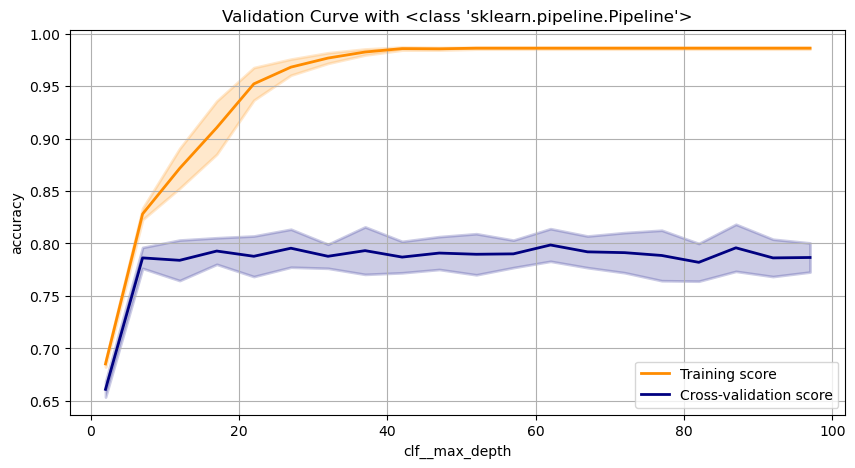

In [54]:
fig = plot_validation_curve(pipe, X_train, y_train, cv=3, n_jobs=-1, param_range=np.arange(2,100,5), param_name='clf__max_depth', scoring='accuracy')

In [ ]:
#max 10 was a good idea
#validation - accuracy nevers get higher thn 80